# Predcition of Hospital Admission Related to Lower Respiratory Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to lower respiratory tract infection (LRTI). We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) and random forest (RF) models.

In [3]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [4]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [5]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [6]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'lrti_date_'+str(i), 'lrti_ab_date_'+str(i), 'lrti_ab_type_'+str(i),
                   'incdt_lrti_date_'+str(i), 'admitted_lrti_date_'+str(i), 'sgss_gp_cov_lrti_date_'+str(i)]]
    
    #drop rows with no lrti reord
    datum = datum[datum['lrti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with lrti_i
    datum = datum[datum['sgss_gp_cov_lrti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'lrti_date_'+str(i): 'lrti_date', 'lrti_ab_date_'+str(i): 'lrti_ab_date', 
                           'lrti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_lrti_date_'+str(i): 'incdt_lrti_date', 'incdt_lrti_type_'+str(i): 'incdt_lrti_type',
                           'admitted_lrti_date_'+str(i): 'admitted_lrti_date',
                           'sgss_gp_cov_lrti_date_'+str(i): 'sgss_gp_cov_lrti_date'},
                inplace=True)
    
    return datum

In [7]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred):

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_tot = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit']]], axis=1)

    #calculate sums
    summary_table = prob_pred_enc_tot.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_tot.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_tot.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [8]:
#summary table of baseline characteristics
def make_summary_table_deciles(infection, infection_type, prob_pred_enc_lr_rf):
    #calculate sums
    summary_table = prob_pred_enc_lr_rf.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr_rf.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr_rf.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_deciles_'+infection+'_'+infection_type+'.csv', index=False)

In [9]:
def cox_build(infection, infection_type, data, data_no_abs): #data_lrti_incdt, data_lrti_no_abs_incdt
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_lrti_admitted',
            event_col='event_lrti_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']
    #prob_pred_lrti_no_abs_incdt

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)
    #prob_pred

    ##add a column for prescribed antibiotics
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    #prob_pred_lrti_no_abs_incdt_bin
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)#, data.pred_mean_train.max() + data.pred_mean_train.max()/3)
    plt.xlim(0)#, data.ab_prob_mean_train.max() + data.ab_prob_mean_train.max()/3)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [10]:
def lr_rf_build_risk_deciles(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nAUROC of LR for deciles with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for deciles with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_deciles_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_deciles_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with deciles", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_deciles_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [11]:
def lr_rf_build_risk_riskfactors(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)#, random_state=42)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nAUROC of LR for risk factors with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for risk factors with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with risk factors", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_riskfactors_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [12]:
def calibration_rf_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val):
    ##calibration for RF
    rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_dev_groupby_bin['ab_binary_proportion'] = rf_prob_pred_dev_groupby_bin['ab_binary_sum']/rf_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_val_groupby_bin['ab_binary_proportion'] = rf_prob_pred_val_groupby_bin['ab_binary_sum']/rf_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of RF model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [13]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_lrti.csv.gz')

In [14]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [15]:
#process 20 lrtis and concatenate them 
data_lrti_1 = proc_infec_data(data,1)
data_lrti_2 = proc_infec_data(data,2)
data_lrti_3 = proc_infec_data(data,3)
data_lrti_4 = proc_infec_data(data,4)
data_lrti_5 = proc_infec_data(data,5)
data_lrti_6 = proc_infec_data(data,6)
data_lrti_7 = proc_infec_data(data,7)
data_lrti_8 = proc_infec_data(data,8)
data_lrti_9 = proc_infec_data(data,9)
data_lrti_10 = proc_infec_data(data,10)
data_lrti_11 = proc_infec_data(data,11)
data_lrti_12 = proc_infec_data(data,12)
data_lrti_13 = proc_infec_data(data,13)
data_lrti_14 = proc_infec_data(data,14)
data_lrti_15 = proc_infec_data(data,15)
data_lrti_16 = proc_infec_data(data,16)
data_lrti_17 = proc_infec_data(data,17)
data_lrti_18 = proc_infec_data(data,18)
data_lrti_19 = proc_infec_data(data,19)
data_lrti_20 = proc_infec_data(data,20)

data_lrti = pd.concat([data_lrti_1, data_lrti_2, data_lrti_3, data_lrti_4, data_lrti_5, data_lrti_6, data_lrti_7, data_lrti_8, data_lrti_9, data_lrti_10, data_lrti_11, data_lrti_12, data_lrti_13, data_lrti_14, data_lrti_15, data_lrti_16, data_lrti_17, data_lrti_18, data_lrti_19, data_lrti_20])
data_lrti.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [16]:
##add variable season
#convert data types
data_lrti['lrti_date'] = data_lrti['lrti_date'].astype('datetime64[ns]')
data_lrti['admitted_lrti_date'] = data_lrti['admitted_lrti_date'].astype('datetime64[ns]')
data_lrti.died_date = data_lrti.died_date.astype('datetime64[ns]')
data_lrti.deregistered_date = data_lrti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_lrti['date'] = data_lrti['lrti_date'] 
data_lrti['date'] = data_lrti['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_lrti with today's date in year and month
data_lrti = data_lrti[data_lrti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_lrti = data_lrti[data_lrti['date'] != last_1_month_date_y_m]
data_lrti = data_lrti[data_lrti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of lrti records
data_lrti['season'] = np.nan
data_lrti['date_month'] = pd.DatetimeIndex(data_lrti['date']).month

conditions = [
    (data_lrti['date_month'] >= 3) & (data_lrti['date_month'] <= 5),
    (data_lrti['date_month'] >= 6) & (data_lrti['date_month'] <= 8),
    (data_lrti['date_month'] >= 9) & (data_lrti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_lrti['season'] = np.select(conditions, choices, default='winter')

In [17]:
#add variable time period
data_lrti.loc[(data_lrti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_lrti.loc[((data_lrti['date'] >= '2020-01') & (data_lrti['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_lrti.loc[(data_lrti['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

In [18]:
data_lrti['date'].max()

'2023-03'

#### event and duration

In [19]:
#scenario 1
#not hosped (nothing happened)
data_lrti.loc[data_lrti['admitted_lrti_date'].isnull(), 'event_lrti_admitted'] = 0

In [20]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_lrti['delta_lrti_admitted'] = (data_lrti['admitted_lrti_date'] - data_lrti['lrti_date']).dt.days
data_lrti.loc[((data_lrti['delta_lrti_admitted'] >= 0) & (data_lrti['delta_lrti_admitted'] <= 30)), 'event_lrti_admitted'] = 1

#scenario 2
#drop whoever was admitted before lrti consultation, i.e. negative value for delta_lrti_admitted
data_lrti = data_lrti[~(data_lrti['delta_lrti_admitted'] < 0)]

In [21]:
#scenario 3
#censor died patients
data_lrti['delta_admitted_died'] = (data_lrti['died_date'] - data_lrti['admitted_lrti_date']).dt.days
data_lrti.loc[data_lrti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_lrti.loc[((data_lrti['delta_admitted_died'] >= 0) & (data_lrti['delta_admitted_died'] <= 30)), 'event_lrti_admitted'] = 0

#scenario 3
#censor deregistered patients
data_lrti['delta_admitted_deregistered'] = (data_lrti['deregistered_date'] - data_lrti['admitted_lrti_date']).dt.days
data_lrti.loc[data_lrti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_lrti.loc[((data_lrti['delta_admitted_deregistered'] > 0) & (data_lrti['delta_admitted_deregistered'] <= 30)), 'event_lrti_admitted'] = 0

#agg scenario 3s
data_lrti['delta_admitted_died_deregistered'] = data_lrti['delta_admitted_deregistered'].combine_first(data_lrti['delta_admitted_died'])
data_lrti.loc[data_lrti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [22]:
#scenario 1
#any other patients (nothing happened)
data_lrti['event_lrti_admitted'] = data_lrti['event_lrti_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_lrti['duration_lrti_admitted'] = data_lrti['delta_lrti_admitted'].combine_first(data_lrti['delta_admitted_died_deregistered'])
data_lrti['duration_lrti_admitted'] = data_lrti['duration_lrti_admitted'].replace(np.NaN, 30)
data_lrti.loc[(data_lrti['duration_lrti_admitted'] > 30), 'duration_lrti_admitted'] = 30

#give value 1 to event_lrti_admitted if duration_lrti_admitted is greater or equal to 0 and less than 30
data_lrti.loc[((data_lrti['duration_lrti_admitted'] >= 0) & (data_lrti['duration_lrti_admitted'] < 30)), 'event_lrti_admitted'] = 1

#drop any rows with value 0 in duration column
data_lrti = data_lrti[~(data_lrti['duration_lrti_admitted'] == 0)]

In [23]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_lrti.loc[((data_lrti['delta_lrti_admitted'] > 0) & (data_lrti['delta_lrti_admitted'] < 30)), 'event_lrti_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [24]:
#drop anybody with age less than 18 or 0!
data_lrti = data_lrti[~(data_lrti['age'] < 18)] 
data_lrti['age'][data_lrti['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_lrti = data_lrti[data_lrti['age_cat'] != '0-4']
data_lrti = data_lrti[data_lrti['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_lrti['bmi'][data_lrti['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_lrti['bmi'] = data_lrti['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_lrti['antibacterial_brit'][data_lrti['antibacterial_brit'] < 0] = np.nan

In [25]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_lrti = data_lrti.replace({"sex": dict_sex})
data_lrti = data_lrti.replace({"smoking": dict_smoking})

In [26]:
#drop rows with missing region
if ('region' in data_lrti.columns) and (data_lrti['region'].isnull().sum() > 0):
   data_lrti = data_lrti[data_lrti['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_lrti.columns) and (data_lrti['antibacterial_brit'].isnull().sum() > 0):
    data_lrti['antibacterial_brit'] = data_lrti['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_lrti.columns) and (data_lrti['ethnicity'].isnull().sum() > 0):
    data_lrti['ethnicity'] = data_lrti['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_lrti.columns) and (data_lrti['smoking'].isnull().sum() > 0):
    data_lrti['smoking'] = data_lrti['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_lrti.columns) and (data_lrti['imd'].isnull().sum() > 0):
    data_lrti['imd'] = data_lrti['imd'].fillna(0)

In [27]:
#missing values of bmi assign 5 and 0; categorise bmi
data_lrti['bmi_cat'] = 5

for idx, x in enumerate(data_lrti['bmi_cat']):
    if data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] >= 30:
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] >= 25) and (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] < 30):
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] >= 18.5) and (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] < 25):
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] < 18.5:
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_lrti.columns) and (data_lrti['bmi_cat'].isnull().sum() > 0):
    data_lrti['bmi_cat'] = data_lrti['bmi_cat'].fillna(0)

In [28]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_lrti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_lrti['ab_type_cat'] = np.where(data_lrti['ab_type'].isin(ab_series[mask].index),'other',data_lrti['ab_type'])
#assign no to non ab users
data_lrti.loc[data_lrti['lrti_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_lrti['ab_type_cat'] = data_lrti['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [29]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_lrti = data_lrti.replace({"sex": dict_sex})
data_lrti = data_lrti.replace({"ethnicity": dict_ethnicity})
data_lrti = data_lrti.replace({"smoking": dict_smoking})
data_lrti = data_lrti.replace({"imd": dict_imd})
data_lrti = data_lrti.replace({"bmi_cat": dict_bmi})
data_lrti = data_lrti.replace({"flu_vaccine": dict_flu})
data_lrti = data_lrti.replace({"region": dict_region})
data_lrti = data_lrti.replace({"age_cat": dict_age})
data_lrti = data_lrti.replace({"ab_type_cat": dict_ab_type})

In [30]:
data_lrti.ethnicity.value_counts('NA')

white      0.601615
unknown    0.247890
other      0.075528
asian      0.074967
Name: ethnicity, dtype: float64

In [31]:
data_lrti.smoking.value_counts('NA')

unknown         0.414015
smoker          0.391665
never_smoked    0.130166
ex_smoker       0.064154
Name: smoking_status, dtype: float64

In [32]:
data_lrti.bmi_cat.value_counts('NA')

obese             0.522375
unknown           0.252023
overweight        0.110314
healthy_weight    0.082849
underweight       0.032439
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [33]:
#categorise CCI
data_lrti['CCI_cat'] = pd.cut(data_lrti['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_lrti['antibacterial_brit'].clip(0, data_lrti['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

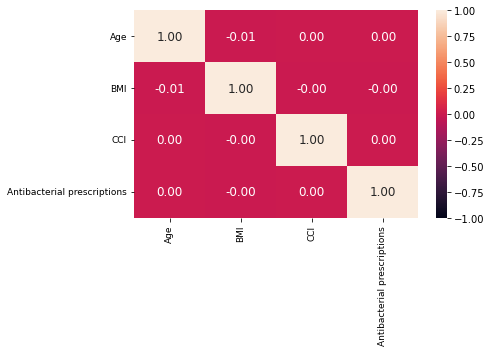

In [34]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_lrti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/corr_lrti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [35]:
data_lrti = data_lrti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                                   'antibacterial_brit', 'lrti_ab_date', 'ab_type_cat', 'incdt_lrti_date', 'date', 'period',
                                   'event_lrti_admitted', 'duration_lrti_admitted'
                                    ]]

In [36]:
#switch variable lrti_ab_date into a binary variable
data_lrti[['ab_binary']] = data_lrti[['lrti_ab_date']].where(data_lrti[['lrti_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_lrti_incdt = data_lrti[data_lrti['incdt_lrti_date'] == 0]
data_lrti_prevl = data_lrti[data_lrti['incdt_lrti_date'] == 1]

#no antibiotics and incident hospital admission
data_lrti_no_abs_incdt = data_lrti_incdt[data_lrti_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_lrti_abs_incdt = data_lrti_incdt[data_lrti_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_lrti_no_abs_prevl = data_lrti_prevl[data_lrti_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_lrti_abs_prevl = data_lrti_prevl[data_lrti_prevl['ab_binary'] == 1]

In [37]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_lrti_incdt_prepandemic = data_lrti_incdt[data_lrti_incdt['period'] == 'prepandemic']
data_lrti_incdt_during_pandemic = data_lrti_incdt[(data_lrti_incdt['period'] == 'during_pandemic')]
data_lrti_incdt_post_2nd_lockdown = data_lrti_incdt[data_lrti_incdt['period'] == 'post_2nd_lockdown']
data_lrti_prevl_prepandemic = data_lrti_prevl[data_lrti_prevl['period'] == 'prepandemic']
data_lrti_prevl_during_pandemic = data_lrti_prevl[(data_lrti_prevl['period'] == 'during_pandemic')]
data_lrti_prevl_post_2nd_lockdown = data_lrti_prevl[data_lrti_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_lrti_no_abs_incdt_prepandemic = data_lrti_incdt_prepandemic[data_lrti_incdt_prepandemic['ab_binary'] == 0]
data_lrti_no_abs_incdt_during_pandemic = data_lrti_incdt_during_pandemic[data_lrti_incdt_during_pandemic['ab_binary'] == 0]
data_lrti_no_abs_incdt_post_2nd_lockdown = data_lrti_incdt_post_2nd_lockdown[data_lrti_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_lrti_no_abs_prevl_prepandemic = data_lrti_prevl_prepandemic[data_lrti_prevl_prepandemic['ab_binary'] == 0]
data_lrti_no_abs_prevl_during_pandemic = data_lrti_prevl_during_pandemic[data_lrti_prevl_during_pandemic['ab_binary'] == 0]
data_lrti_no_abs_prevl_post_2nd_lockdown = data_lrti_prevl_post_2nd_lockdown[data_lrti_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [38]:
#store data for plotting hosp admission counts and percentages
%store data_lrti
# save data
data_lrti.to_csv('../output/hospitalisation_prediction_lrti/data_lrti.csv')

Stored 'data_lrti' (DataFrame)


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-0- summary tables

In [39]:
#make summary tables
make_summary_table('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt)
make_summary_table('lrti', 'abs_incdt', data_lrti_abs_incdt)
make_summary_table('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl)
make_summary_table('lrti', 'abs_prevl', data_lrti_abs_prevl)

### 5-1- incident

<lifelines.CoxPHFitter: fitted with 108226 total observations, 107529 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 108226
number of events observed = 697
   partial log-likelihood = -8057.62
         time fit was run = 2023-06-29 10:59:12 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.03       1.03       0.11            -0.19             0.26                 0.83                 1.29
CCI_cat[T.medium]                0.12       1.13       0.12            -0.12             0.37                 0.89                 1.44
CCI_cat[T.high]                 -0.11       0.89       0.16            -0.42             0.20                 0.66                 1.22
CCI_cat[T.very_high]             0.09       1.10       0.13            -0.16             0.35                 0.85                 1.41
age_cat[T.25_34]                 0.04       1.04       0.14            -0.24             0.31                 0.79                 1.37
age_cat[T.35_44]                 0.03       1.03       0.14            -0.25             0.31                 0.78                 1.36
age_cat[T.45_54]                 0.07       1.07       0.14            -0.21             0.34                 0.81                 1.41
age_cat[T.55_64]                -0.16       0.85       0.15            -0.45             0.13                 0.64                 1.14
age_cat[T.65_74]                -0.05       0.95       0.14            -0.34             0.23                 0.71                 1.25
age_cat[T.75_more]               0.10       1.10       0.14            -0.18             0.37                 0.84                 1.44
antibacterial_brit               0.03       1.03       0.03            -0.02             0.08                 0.98                 1.09
bmi_cat[T.obese]                 0.10       1.10       0.14            -0.18             0.38                 0.83                 1.46
bmi_cat[T.overweight]            0.11       1.11       0.17            -0.23             0.45                 0.79                 1.57
bmi_cat[T.underweight]           0.32       1.38       0.23            -0.12             0.77                 0.89                 2.16
bmi_cat[T.unknown]              -0.11       0.90       0.16            -0.42             0.20                 0.66                 1.22
ethnicity[T.other]               0.23       1.25       0.20            -0.17             0.62                 0.85                 1.86
ethnicity[T.unknown]             0.29       1.34       0.17            -0.04             0.62                 0.96                 1.85
ethnicity[T.white]               0.12       1.13       0.16            -0.19             0.43                 0.83                 1.54
flu_vaccine[T.yes]               0.24       1.27       0.12             0.01             0.47                 1.01                 1.60
imd[T.medium]                    0.05       1.05       0.12            -0.18             0.28                 0.84                 1.33
imd[T.unaffluent]               -0.02       0.98       0.12            -0.26             0.21                 0.77                 1.24
imd[T.unknown]                  -0.23       0.80       0.20            -0.63             0.17                 0.53                 1.19
imd[T.very_affluent]            -0.15       0.86       0.12            -0.40             0.09                 0.67                 1.09
imd[T.very_unaffluent]          -0.11       0.90       0.12            -0.35             0.13                 0.70                 1.14
region[T.east_midlands]          0.11       1.11       0.17      

13043


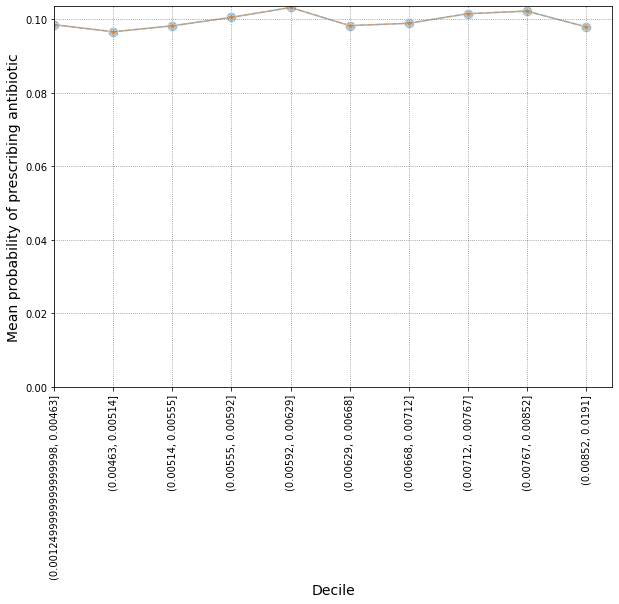


AUROC of LR for deciles with development and validation data: 0.50646 and 0.49948
AUROC of RF for deciles with development and validation data: 0.50644 and 0.50016
LR coefficients:
                                              OR  Lower CI  Upper CI
bins_(0.0012499999999999998, 0.00463]  0.111449  0.105017  0.118276
bins_(0.00463, 0.00514]                0.109501  0.103150  0.116243
bins_(0.00514, 0.00555]                0.109161  0.102831  0.115880
bins_(0.00555, 0.00592]                0.115267  0.108684  0.122248
bins_(0.00592, 0.00629]                0.112869  0.106381  0.119752
bins_(0.00629, 0.00668]                0.106322  0.100043  0.112995
bins_(0.00668, 0.00712]                0.112372  0.105909  0.119229
bins_(0.00712, 0.00767]                0.113805  0.107274  0.120734
bins_(0.00767, 0.00852]                0.113299  0.106770  0.120227
bins_(0.00852, 0.0191]                 0.109333  0.102961  0.116099

RF feature importance:
                                         rf_c

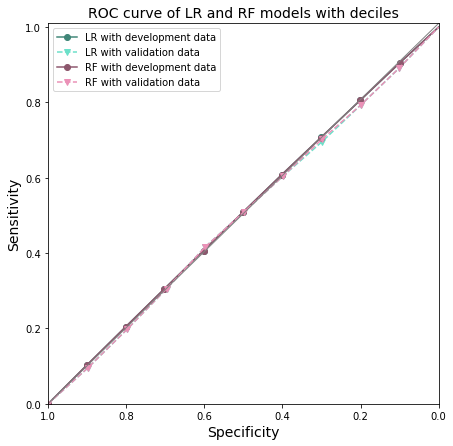

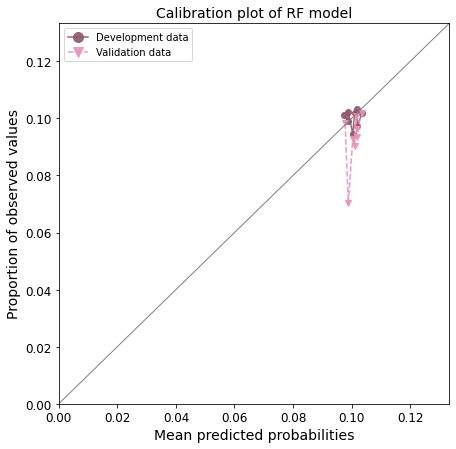

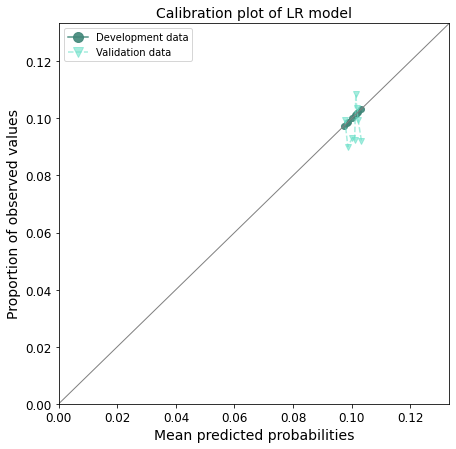


AUROC of LR for risk factors with development and validation data: 0.51868 and 0.50031
AUROC of RF for risk factors with development and validation data: 0.59834 and 0.50066
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.928567       NaN       NaN
age_cat_25_34                0.841338       NaN       NaN
age_cat_35_44                0.895337       NaN       NaN
age_cat_45_54                0.903748       NaN       NaN
age_cat_55_64                0.882011       NaN       NaN
age_cat_65_74                0.896779       NaN       NaN
age_cat_75_more              0.854675       NaN       NaN
sex_female                   0.650366  0.000000       inf
sex_male                     0.657084  0.000000       inf
CCI_cat_high                 0.832309  0.000000       inf
CCI_cat_low                  0.837826  0.000000       inf
CCI_cat_medium               0.854652  0.000000       inf
CCI_cat_very_high            0.876934  0.000000      

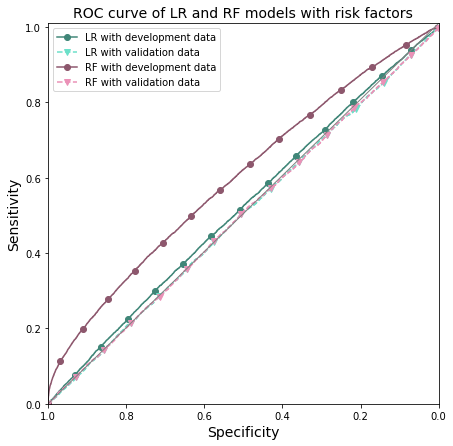

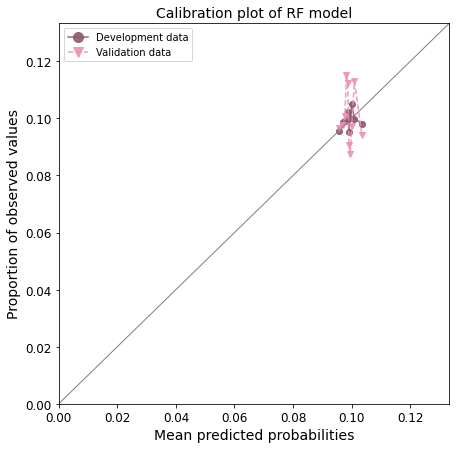

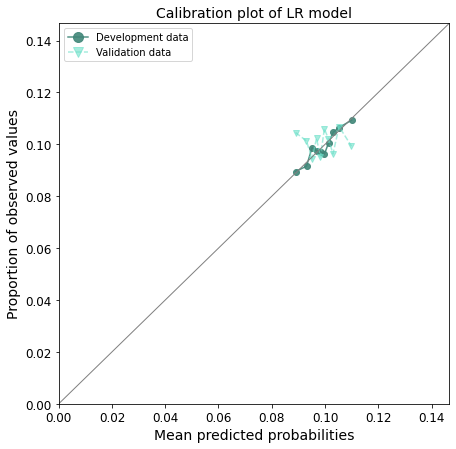

In [40]:
#build cox model for hosp prediction using non ab users' data
prob_pred_lrti_no_abs_incdt, prob_pred_lrti_no_abs_incdt_bin = cox_build('lrti', 'incdt', data_lrti_incdt, data_lrti_no_abs_incdt)

#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_deciles('lrti', 'incdt_deciles', prob_pred_lrti_no_abs_incdt)

#make summary table of deciles
make_summary_table_deciles('lrti', 'incdt', prob_pred_enc_lr_rf_incdt)

#calibration plots of rf and lr with deciles
calibration_rf_lr('lrti', 'incdt_deciles', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)

#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_riskfactors('lrti', 'incdt_riskfactors', prob_pred_lrti_no_abs_incdt)

#calibration plots of rf and lr with risk factors
calibration_rf_lr('lrti', 'incdt_riskfactors', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 12038 total observations, 11958 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 12038
number of events observed = 80
   partial log-likelihood = -733.48
         time fit was run = 2023-06-29 11:00:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.29       1.34       0.35            -0.39             0.98                 0.68                 2.66
CCI_cat[T.medium]                0.36       1.43       0.38            -0.38             1.09                 0.68                 2.99
CCI_cat[T.high]                 -0.20       0.82       0.51            -1.19             0.80                 0.30                 2.22
CCI_cat[T.very_high]            -0.01       0.99       0.43            -0.84             0.83                 0.43                 2.30
age_cat[T.25_34]                 0.40       1.49       0.46            -0.50             1.29                 0.61                 3.65
age_cat[T.35_44]                 0.51       1.66       0.45            -0.38             1.39                 0.69                 4.01
age_cat[T.45_54]                 0.20       1.22       0.48            -0.73             1.13                 0.48                 3.10
age_cat[T.55_64]                 0.26       1.29       0.48            -0.68             1.19                 0.51                 3.28
age_cat[T.65_74]                 0.46       1.58       0.45            -0.42             1.34                 0.66                 3.83
age_cat[T.75_more]               0.57       1.76       0.44            -0.30             1.44                 0.74                 4.21
antibacterial_brit               0.07       1.07       0.08            -0.08             0.22                 0.92                 1.25
bmi_cat[T.obese]                 0.10       1.10       0.44            -0.76             0.96                 0.47                 2.60
bmi_cat[T.overweight]            0.31       1.37       0.51            -0.69             1.31                 0.50                 3.70
bmi_cat[T.underweight]           1.17       3.21       0.56             0.07             2.26                 1.07                 9.60
bmi_cat[T.unknown]              -0.18       0.84       0.48            -1.13             0.77                 0.32                 2.16
ethnicity[T.other]               0.23       1.26       0.52            -0.79             1.24                 0.45                 3.47
ethnicity[T.unknown]            -0.13       0.88       0.44            -1.00             0.74                 0.37                 2.09
ethnicity[T.white]              -0.15       0.86       0.41            -0.95             0.65                 0.39                 1.91
flu_vaccine[T.yes]              -0.22       0.80       0.43            -1.06             0.61                 0.35                 1.84
imd[T.medium]                   -0.41       0.66       0.39            -1.18             0.35                 0.31                 1.43
imd[T.unaffluent]                0.07       1.07       0.34            -0.61             0.74                 0.54                 2.10
imd[T.unknown]                   0.40       1.49       0.48            -0.54             1.34                 0.58                 3.80
imd[T.very_affluent]            -0.15       0.86       0.37            -0.86             0.57                 0.42                 1.77
imd[T.very_unaffluent]          -0.10       0.91       0.36            -0.80             0.61                 0.45                 1.84
region[T.east_midlands]          0.16       1.17       0.49           

13036


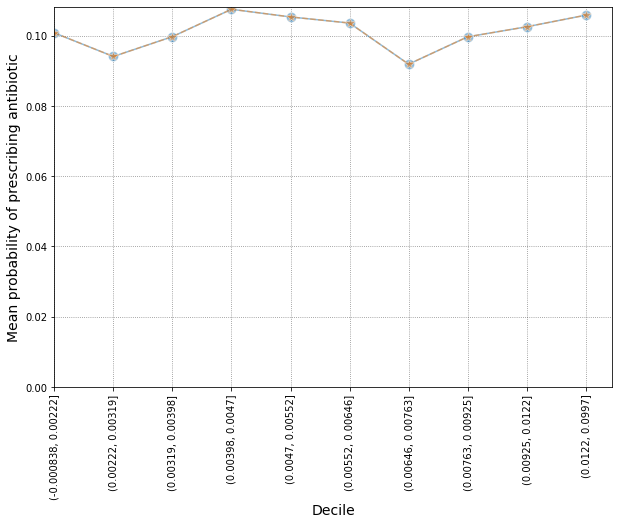


AUROC of LR for deciles with development and validation data: 0.51036 and 0.51033
AUROC of RF for deciles with development and validation data: 0.51021 and 0.50525
LR coefficients:
                                  OR  Lower CI  Upper CI
bins_(-0.000838, 0.00222]  0.116764  0.098013  0.139102
bins_(0.00222, 0.00319]    0.105130  0.087436  0.126405
bins_(0.00319, 0.00398]    0.113955  0.095556  0.135897
bins_(0.00398, 0.0047]     0.117012  0.098281  0.139314
bins_(0.0047, 0.00552]     0.110927  0.092797  0.132599
bins_(0.00552, 0.00646]    0.117949  0.098874  0.140704
bins_(0.00646, 0.00763]    0.107950  0.090019  0.129452
bins_(0.00763, 0.00925]    0.114122  0.095755  0.136011
bins_(0.00925, 0.0122]     0.107997  0.090184  0.129328
bins_(0.0122, 0.0997]      0.114821  0.096457  0.136681

RF feature importance:
                             rf_coef
bins_(0.00222, 0.00319]    0.129903
bins_(0.00763, 0.00925]    0.114765
bins_(-0.000838, 0.00222]  0.112195
bins_(0.00646, 0.00763]    0.109

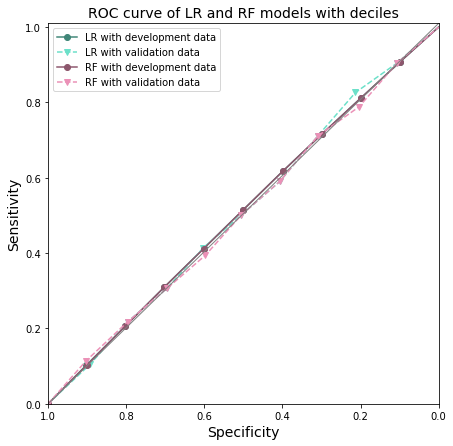

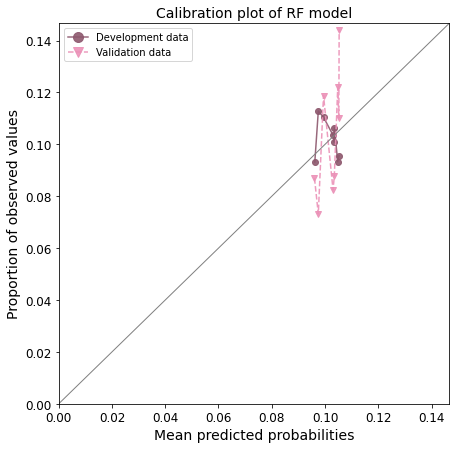

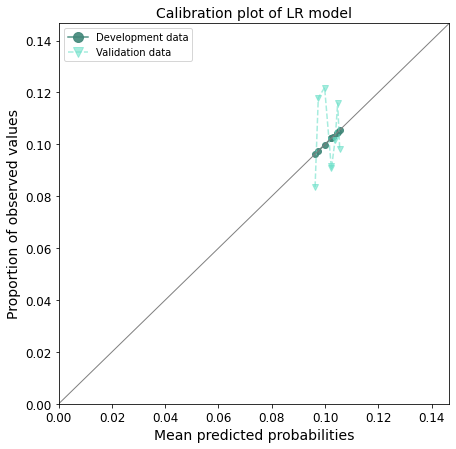


AUROC of LR for risk factors with development and validation data: 0.54033 and 0.50522
AUROC of RF for risk factors with development and validation data: 0.77472 and 0.51681
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.804520       NaN       NaN
age_cat_25_34                0.937447       NaN       NaN
age_cat_35_44                0.871027       NaN       NaN
age_cat_45_54                0.884421       NaN       NaN
age_cat_55_64                0.850356       NaN       NaN
age_cat_65_74                0.957750       NaN       NaN
age_cat_75_more              0.919745       NaN       NaN
sex_female                   0.686773  0.000000       inf
sex_male                     0.633696  0.000000       inf
CCI_cat_high                 0.832469  0.000000       inf
CCI_cat_low                  0.848106  0.000000       inf
CCI_cat_medium               0.845656  0.000000       inf
CCI_cat_very_high            0.861228  0.000000      

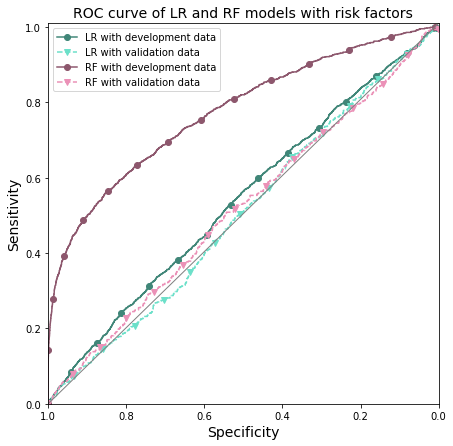

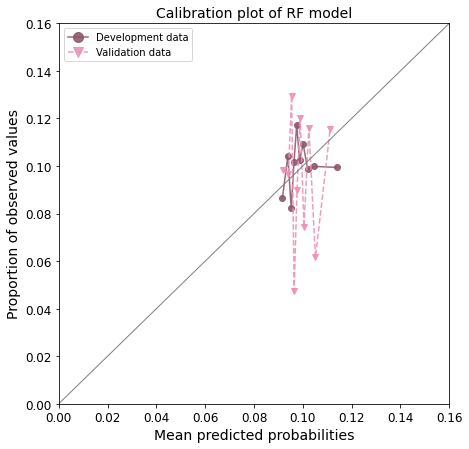

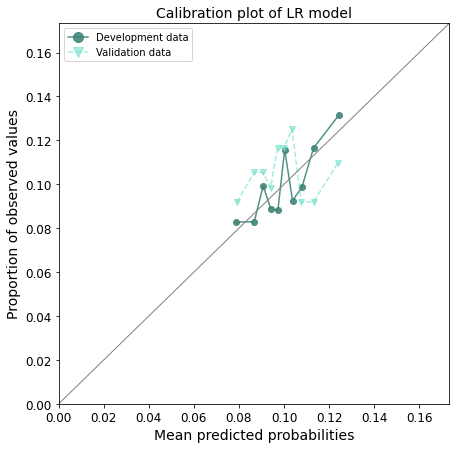

In [41]:
#build cox model for hosp prediction using non ab users' data
prob_pred_lrti_no_abs_prevl, prob_pred_lrti_no_abs_prevl_bin = cox_build('lrti', 'prevl', data_lrti_prevl, data_lrti_no_abs_prevl)

#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_deciles('lrti', 'prevl_deciles', prob_pred_lrti_no_abs_prevl)

#make summary table of deciles
make_summary_table_deciles('lrti', 'prevl', prob_pred_enc_lr_rf_prevl)

#calibration plots of rf and lr with deciles
calibration_rf_lr('lrti', 'prevl_deciles', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)

#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_riskfactors('lrti', 'prevl_riskfactors', prob_pred_lrti_no_abs_prevl)

#calibration plots of rf and lr with risk factors
calibration_rf_lr('lrti', 'prevl_riskfactors', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 28560 total observations, 28405 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 28560
number of events observed = 155
   partial log-likelihood = -1560.79
         time fit was run = 2023-06-29 11:00:23 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.12       0.89       0.23            -0.57             0.33                 0.56                 1.40
CCI_cat[T.medium]                0.02       1.02       0.25            -0.47             0.51                 0.63                 1.66
CCI_cat[T.high]                 -1.12       0.33       0.45            -2.00            -0.24                 0.14                 0.78
CCI_cat[T.very_high]             0.06       1.06       0.26            -0.44             0.57                 0.64                 1.77
age_cat[T.25_34]                 0.07       1.07       0.30            -0.51             0.66                 0.60                 1.93
age_cat[T.35_44]                -0.04       0.96       0.31            -0.64             0.56                 0.53                 1.75
age_cat[T.45_54]                 0.01       1.01       0.30            -0.58             0.60                 0.56                 1.83
age_cat[T.55_64]                -0.19       0.82       0.32            -0.82             0.43                 0.44                 1.54
age_cat[T.65_74]                -0.38       0.68       0.34            -1.04             0.28                 0.35                 1.32
age_cat[T.75_more]               0.47       1.60       0.27            -0.07             1.01                 0.93                 2.73
antibacterial_brit              -0.00       1.00       0.06            -0.11             0.11                 0.89                 1.11
bmi_cat[T.obese]                 0.01       1.01       0.29            -0.56             0.57                 0.57                 1.78
bmi_cat[T.overweight]           -0.09       0.91       0.37            -0.81             0.63                 0.44                 1.87
bmi_cat[T.underweight]           0.50       1.65       0.43            -0.34             1.34                 0.71                 3.81
bmi_cat[T.unknown]              -0.30       0.74       0.32            -0.94             0.33                 0.39                 1.39
ethnicity[T.other]               0.22       1.24       0.42            -0.61             1.04                 0.54                 2.83
ethnicity[T.unknown]             0.35       1.42       0.35            -0.33             1.03                 0.72                 2.80
ethnicity[T.white]              -0.00       1.00       0.34            -0.66             0.66                 0.52                 1.93
flu_vaccine[T.yes]               0.49       1.63       0.23             0.04             0.94                 1.04                 2.56
imd[T.medium]                   -0.13       0.88       0.23            -0.58             0.32                 0.56                 1.38
imd[T.unaffluent]               -0.43       0.65       0.25            -0.93             0.06                 0.40                 1.06
imd[T.unknown]                  -0.28       0.75       0.39            -1.04             0.48                 0.35                 1.61
imd[T.very_affluent]            -0.67       0.51       0.27            -1.20            -0.14                 0.30                 0.87
imd[T.very_unaffluent]          -0.52       0.60       0.26            -1.03            -0.01                 0.36                 0.99
region[T.east_midlands]         -0.08       0.92       0.40         

13048


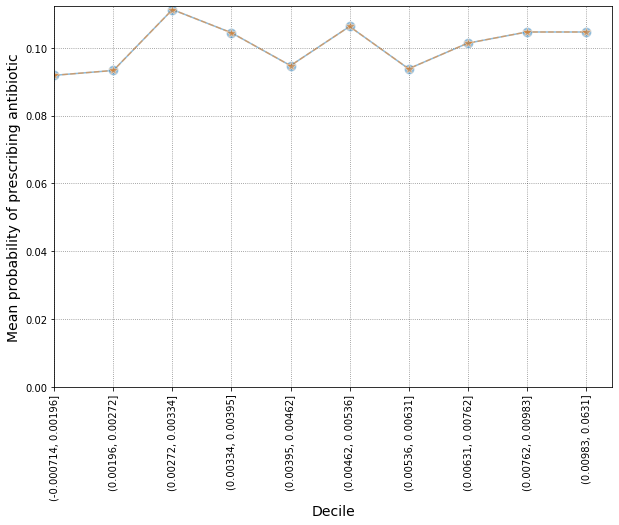


AUROC of LR for deciles with development and validation data: 0.52270 and 0.50566
AUROC of RF for deciles with development and validation data: 0.52270 and 0.50566
LR coefficients:
                                  OR  Lower CI  Upper CI
bins_(-0.000714, 0.00196]  0.100450  0.089026  0.113341
bins_(0.00196, 0.00272]    0.104504  0.092731  0.117772
bins_(0.00272, 0.00334]    0.126676  0.113504  0.141377
bins_(0.00334, 0.00395]    0.118188  0.105517  0.132381
bins_(0.00395, 0.00462]    0.099480  0.088115  0.112311
bins_(0.00462, 0.00536]    0.120253  0.107493  0.134528
bins_(0.00536, 0.00631]    0.101865  0.090365  0.114827
bins_(0.00631, 0.00762]    0.114528  0.102091  0.128480
bins_(0.00762, 0.00983]    0.112898  0.100628  0.126663
bins_(0.00983, 0.0631]     0.117709  0.105145  0.131774

RF feature importance:
                             rf_coef
bins_(0.00272, 0.00334]    0.192089
bins_(0.00395, 0.00462]    0.144706
bins_(-0.000714, 0.00196]  0.142909
bins_(0.00536, 0.00631]    0.118

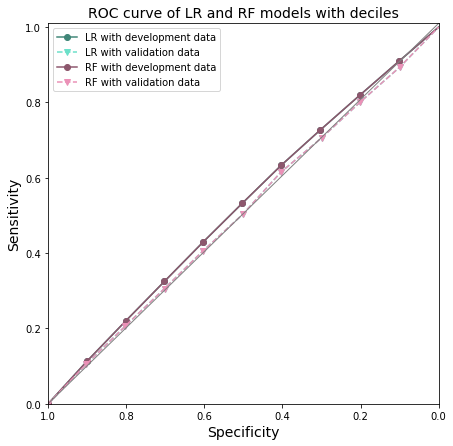

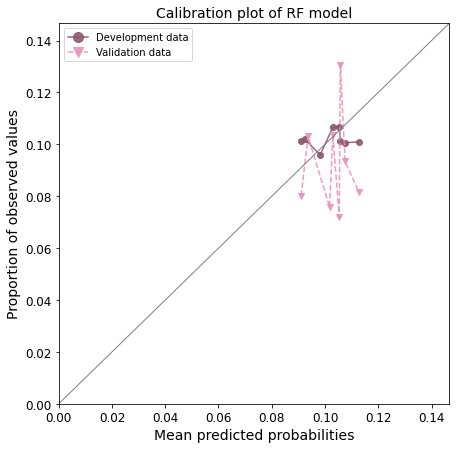

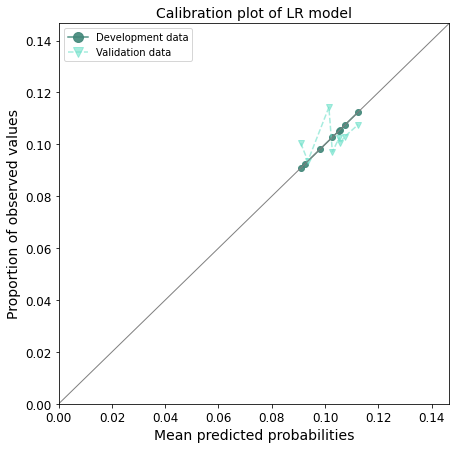

In [42]:
#build cox model for hosp prediction using non ab users' data
prob_pred_lrti_no_abs_incdt_prepandemic, prob_pred_lrti_no_abs_incdt_prepandemic_bin = cox_build('lrti', 'incdt_prepandemic', data_lrti_incdt_prepandemic, data_lrti_no_abs_incdt_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic = lr_rf_build_risk_deciles('lrti', 'incdt_prepandemic', prob_pred_lrti_no_abs_incdt_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('lrti', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic)

<lifelines.CoxPHFitter: fitted with 33134 total observations, 32923 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 33134
number of events observed = 211
   partial log-likelihood = -2183.37
         time fit was run = 2023-06-29 11:00:39 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.17       0.85       0.21            -0.57             0.24                 0.57                 1.27
CCI_cat[T.medium]                0.06       1.06       0.22            -0.37             0.49                 0.69                 1.63
CCI_cat[T.high]                 -0.07       0.93       0.27            -0.61             0.47                 0.55                 1.59
CCI_cat[T.very_high]             0.04       1.04       0.23            -0.41             0.49                 0.66                 1.63
age_cat[T.25_34]                 0.01       1.01       0.25            -0.48             0.50                 0.62                 1.65
age_cat[T.35_44]                -0.22       0.80       0.26            -0.74             0.29                 0.48                 1.34
age_cat[T.45_54]                 0.00       1.00       0.25            -0.49             0.49                 0.62                 1.63
age_cat[T.55_64]                -0.16       0.85       0.26            -0.66             0.35                 0.51                 1.42
age_cat[T.65_74]                -0.13       0.87       0.25            -0.63             0.36                 0.53                 1.44
age_cat[T.75_more]              -0.09       0.91       0.25            -0.59             0.41                 0.56                 1.51
antibacterial_brit               0.02       1.02       0.05            -0.07             0.11                 0.93                 1.12
bmi_cat[T.obese]                 0.21       1.23       0.27            -0.33             0.75                 0.72                 2.11
bmi_cat[T.overweight]            0.06       1.06       0.34            -0.61             0.72                 0.55                 2.06
bmi_cat[T.underweight]           0.30       1.35       0.44            -0.56             1.16                 0.57                 3.19
bmi_cat[T.unknown]               0.03       1.03       0.30            -0.55             0.61                 0.58                 1.84
ethnicity[T.other]               0.21       1.23       0.36            -0.50             0.92                 0.61                 2.51
ethnicity[T.unknown]             0.10       1.10       0.30            -0.49             0.69                 0.61                 1.99
ethnicity[T.white]               0.14       1.16       0.28            -0.41             0.70                 0.67                 2.01
flu_vaccine[T.yes]              -0.05       0.95       0.24            -0.51             0.41                 0.60                 1.51
imd[T.medium]                    0.09       1.09       0.21            -0.33             0.51                 0.72                 1.66
imd[T.unaffluent]                0.03       1.03       0.22            -0.40             0.46                 0.67                 1.59
imd[T.unknown]                  -0.21       0.81       0.37            -0.93             0.51                 0.39                 1.66
imd[T.very_affluent]            -0.22       0.81       0.23            -0.67             0.24                 0.51                 1.27
imd[T.very_unaffluent]          -0.07       0.93       0.22            -0.51             0.37                 0.60                 1.45
region[T.east_midlands]         -0.05       0.95       0.31         

13045


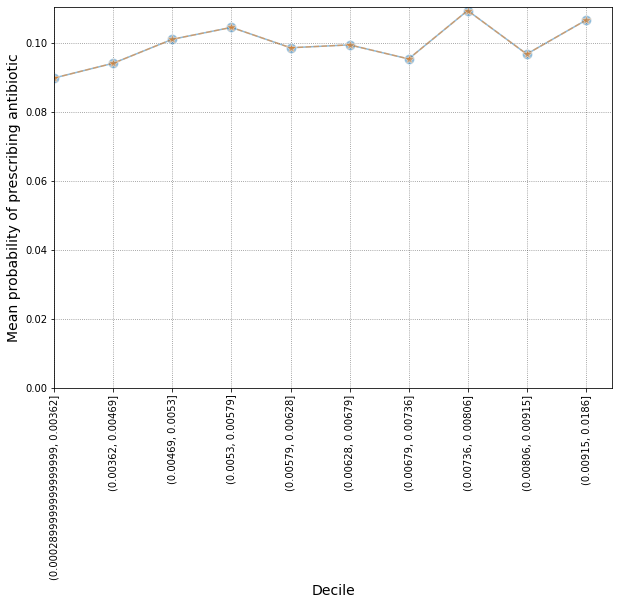


AUROC of LR for deciles with development and validation data: 0.51873 and 0.51068
AUROC of RF for deciles with development and validation data: 0.51872 and 0.50963
LR coefficients:
                                              OR  Lower CI  Upper CI
bins_(0.0002899999999999999, 0.00362]  0.098380  0.087832  0.110196
bins_(0.00362, 0.00469]                0.105342  0.094399  0.117552
bins_(0.00469, 0.0053]                 0.110499  0.099117  0.123188
bins_(0.0053, 0.00579]                 0.121424  0.109441  0.134720
bins_(0.00579, 0.00628]                0.109643  0.098412  0.122155
bins_(0.00628, 0.00679]                0.112230  0.100924  0.124801
bins_(0.00679, 0.00736]                0.103675  0.092826  0.115792
bins_(0.00736, 0.00806]                0.123472  0.111348  0.136916
bins_(0.00806, 0.00915]                0.112090  0.100655  0.124823
bins_(0.00915, 0.0186]                 0.116943  0.105169  0.130035

RF feature importance:
                                         rf_c

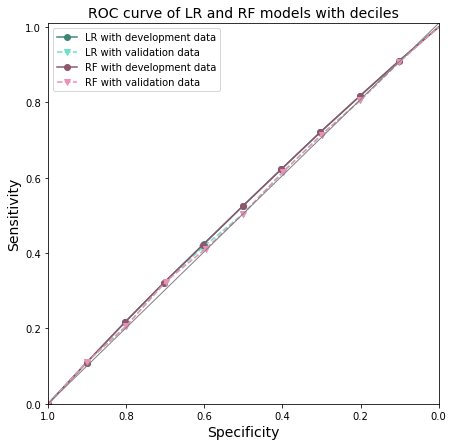

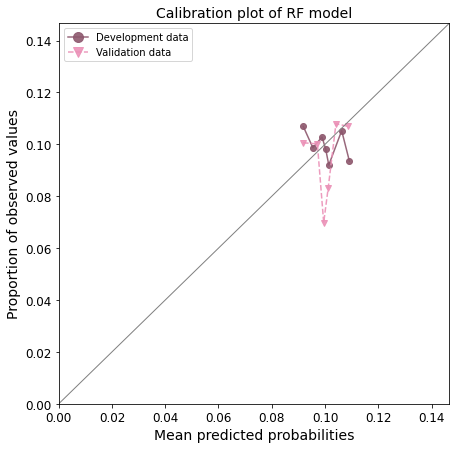

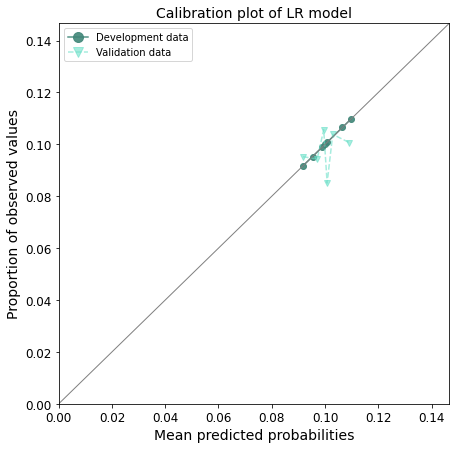

In [43]:
#build cox model for hosp prediction using non ab users' data
prob_pred_lrti_no_abs_incdt_during_pandemic, prob_pred_lrti_no_abs_incdt_during_pandemic_bin = cox_build('lrti', 'incdt_during_pandemic', data_lrti_incdt_during_pandemic, data_lrti_no_abs_incdt_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic = lr_rf_build_risk_deciles('lrti', 'incdt_during_pandemic', prob_pred_lrti_no_abs_incdt_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('lrti', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic)

<lifelines.CoxPHFitter: fitted with 46531 total observations, 46197 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 46531
number of events observed = 334
   partial log-likelihood = -3567.09
         time fit was run = 2023-06-29 11:00:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.15       1.16       0.17            -0.18             0.48                 0.83                 1.61
CCI_cat[T.medium]                0.04       1.04       0.19            -0.33             0.41                 0.72                 1.51
CCI_cat[T.high]                  0.01       1.01       0.23            -0.44             0.46                 0.65                 1.59
CCI_cat[T.very_high]             0.27       1.31       0.19            -0.10             0.63                 0.90                 1.89
age_cat[T.25_34]                -0.16       0.85       0.20            -0.56             0.23                 0.57                 1.26
age_cat[T.35_44]                -0.06       0.94       0.20            -0.45             0.32                 0.64                 1.38
age_cat[T.45_54]                -0.09       0.91       0.20            -0.48             0.30                 0.62                 1.35
age_cat[T.55_64]                -0.26       0.77       0.21            -0.66             0.15                 0.52                 1.16
age_cat[T.65_74]                -0.12       0.88       0.20            -0.51             0.27                 0.60                 1.31
age_cat[T.75_more]              -0.16       0.85       0.20            -0.55             0.24                 0.57                 1.27
antibacterial_brit               0.02       1.02       0.04            -0.05             0.10                 0.95                 1.10
bmi_cat[T.obese]                 0.17       1.19       0.21            -0.24             0.59                 0.78                 1.81
bmi_cat[T.overweight]            0.01       1.01       0.27            -0.51             0.53                 0.60                 1.71
bmi_cat[T.underweight]           0.24       1.27       0.35            -0.45             0.93                 0.64                 2.53
bmi_cat[T.unknown]               0.07       1.08       0.23            -0.37             0.52                 0.69                 1.69
ethnicity[T.other]               0.23       1.26       0.27            -0.30             0.77                 0.74                 2.16
ethnicity[T.unknown]             0.20       1.23       0.23            -0.24             0.65                 0.78                 1.92
ethnicity[T.white]              -0.04       0.96       0.22            -0.46             0.39                 0.63                 1.47
flu_vaccine[T.yes]               0.16       1.18       0.17            -0.18             0.50                 0.84                 1.65
imd[T.medium]                    0.27       1.32       0.17            -0.07             0.61                 0.94                 1.85
imd[T.unaffluent]                0.15       1.16       0.18            -0.20             0.50                 0.82                 1.65
imd[T.unknown]                  -0.21       0.81       0.32            -0.83             0.41                 0.44                 1.51
imd[T.very_affluent]             0.01       1.01       0.18            -0.35             0.38                 0.71                 1.46
imd[T.very_unaffluent]          -0.01       0.99       0.19            -0.38             0.35                 0.69                 1.43
region[T.east_midlands]         -0.10       0.90       0.22         

13043


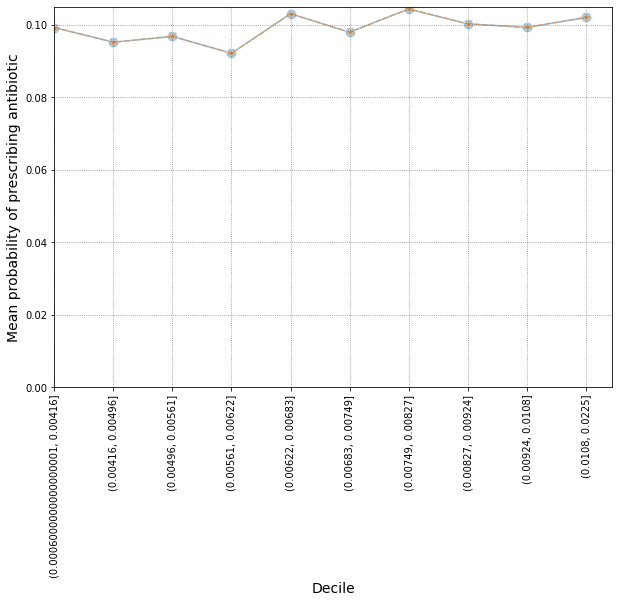


AUROC of LR for deciles with development and validation data: 0.51233 and 0.50470
AUROC of RF for deciles with development and validation data: 0.51229 and 0.50346
LR coefficients:
                                              OR  Lower CI  Upper CI
bins_(0.0006000000000000001, 0.00416]  0.111231  0.101569  0.121811
bins_(0.00416, 0.00496]                0.103478  0.094242  0.113618
bins_(0.00496, 0.00561]                0.109644  0.100110  0.120088
bins_(0.00561, 0.00622]                0.102944  0.093704  0.113096
bins_(0.00622, 0.00683]                0.118803  0.108699  0.129847
bins_(0.00683, 0.00749]                0.107212  0.097748  0.117592
bins_(0.00749, 0.00827]                0.116753  0.106780  0.127659
bins_(0.00827, 0.00924]                0.109968  0.100386  0.120465
bins_(0.00924, 0.0108]                 0.108154  0.098693  0.118522
bins_(0.0108, 0.0225]                  0.112643  0.102906  0.123300

RF feature importance:
                                         rf_c

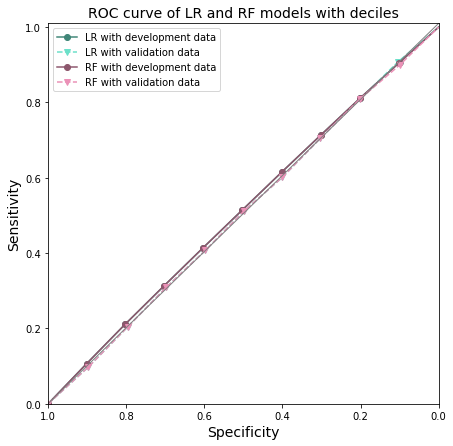

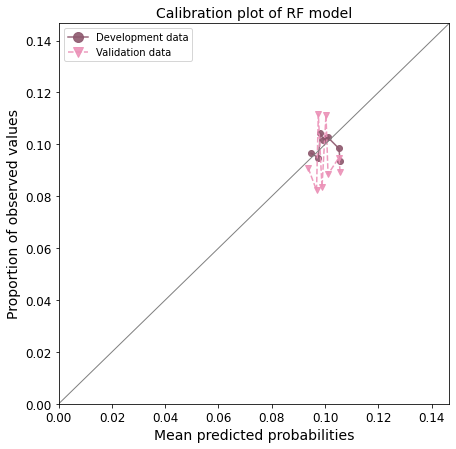

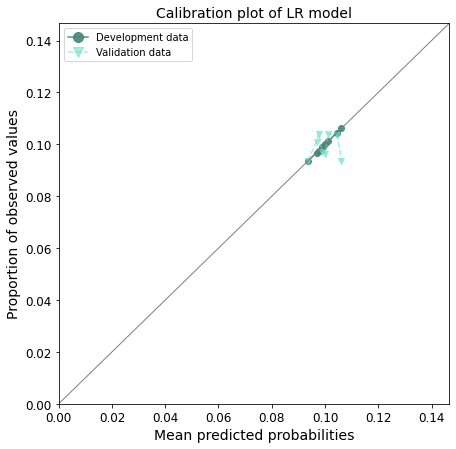

In [44]:
#build cox model for hosp prediction using non ab users' data
prob_pred_lrti_no_abs_incdt_post_2nd_lockdown, prob_pred_lrti_no_abs_incdt_post_2nd_lockdown_bin = cox_build('lrti', 'incdt_post_2nd_lockdown', data_lrti_incdt_post_2nd_lockdown, data_lrti_no_abs_incdt_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown = lr_rf_build_risk_deciles('lrti', 'incdt_post_2nd_lockdown', prob_pred_lrti_no_abs_incdt_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('lrti', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown)

#### 5-3-2- prevalent

<lifelines.CoxPHFitter: fitted with 3235 total observations, 3210 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 3235
number of events observed = 25
   partial log-likelihood = -183.05
         time fit was run = 2023-06-29 11:01:13 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.35       1.42       0.53            -0.68             1.38                 0.51                 3.99
CCI_cat[T.medium]               -0.13       0.88       0.64            -1.38             1.12                 0.25                 3.08
CCI_cat[T.high]                 -1.16       0.31       1.10            -3.32             0.99                 0.04                 2.70
CCI_cat[T.very_high]           -18.18       0.00    3890.17         -7642.77          7606.42                 0.00                  inf
age_cat[T.25_34]                -0.87       0.42       0.84            -2.52             0.79                 0.08                 2.20
age_cat[T.35_44]                -1.64       0.19       1.10            -3.80             0.52                 0.02                 1.69
age_cat[T.45_54]                 0.23       1.25       0.62            -0.98             1.43                 0.37                 4.20
age_cat[T.55_64]                 0.04       1.04       0.64            -1.22             1.30                 0.29                 3.67
age_cat[T.65_74]                -0.50       0.61       0.74            -1.94             0.95                 0.14                 2.58
age_cat[T.75_more]              -0.55       0.58       0.74            -2.00             0.90                 0.13                 2.46
antibacterial_brit               0.11       1.12       0.14            -0.16             0.38                 0.85                 1.47
bmi_cat[T.obese]                -0.94       0.39       0.61            -2.13             0.25                 0.12                 1.28
bmi_cat[T.overweight]           -0.12       0.88       0.72            -1.53             1.28                 0.22                 3.60
bmi_cat[T.underweight]         -18.56       0.00    8256.55        -16201.10         16163.98                 0.00                  inf
bmi_cat[T.unknown]              -0.56       0.57       0.64            -1.81             0.69                 0.16                 2.00
ethnicity[T.other]              17.89   5.87e+07    5564.30        -10887.94         10923.72                 0.00                  inf
ethnicity[T.unknown]            17.88   5.80e+07    5564.30        -10887.95         10923.70                 0.00                  inf
ethnicity[T.white]              17.80   5.39e+07    5564.30        -10888.03         10923.63                 0.00                  inf
flu_vaccine[T.yes]              -0.76       0.47       1.03            -2.78             1.26                 0.06                 3.52
imd[T.medium]                    0.27       1.31       0.77            -1.24             1.79                 0.29                 5.96
imd[T.unaffluent]                0.70       2.01       0.71            -0.70             2.10                 0.50                 8.14
imd[T.unknown]                   0.29       1.33       1.17            -2.00             2.57                 0.14                13.11
imd[T.very_affluent]             0.72       2.06       0.72            -0.68             2.13                 0.51                 8.38
imd[T.very_unaffluent]           0.54       1.71       0.74            -0.91             1.99                 0.40                 7.28
region[T.east_midlands]          0.25       1.29       0.77            -1

13109


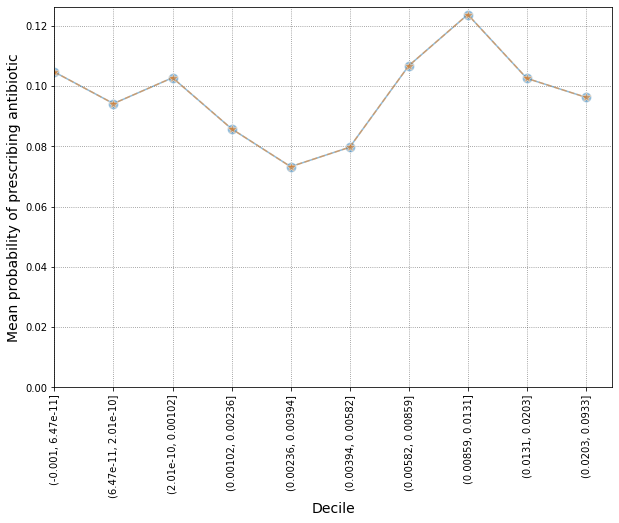


AUROC of LR for deciles with development and validation data: 0.54653 and 0.52509
AUROC of RF for deciles with development and validation data: 0.54653 and 0.52621
LR coefficients:
                                  OR  Lower CI  Upper CI
bins_(-0.001, 6.47e-11]    0.117460  0.083553  0.165127
bins_(0.00102, 0.00236]    0.090909  0.062940  0.131306
bins_(0.00236, 0.00394]    0.067278  0.043691  0.103599
bins_(0.00394, 0.00582]    0.090909  0.062559  0.132107
bins_(0.00582, 0.00859]    0.103550  0.073115  0.146655
bins_(0.00859, 0.0131]     0.131148  0.094323  0.182348
bins_(0.0131, 0.0203]      0.121711  0.086521  0.171213
bins_(0.0203, 0.0933]      0.099398  0.069504  0.142148
bins_(2.01e-10, 0.00102]   0.094225  0.065200  0.136172
bins_(6.47e-11, 2.01e-10]  0.096096  0.066860  0.138116

RF feature importance:
                             rf_coef
bins_(0.00236, 0.00394]    0.209176
bins_(0.00859, 0.0131]     0.189961
bins_(0.0131, 0.0203]      0.127631
bins_(-0.001, 6.47e-11]    0.088

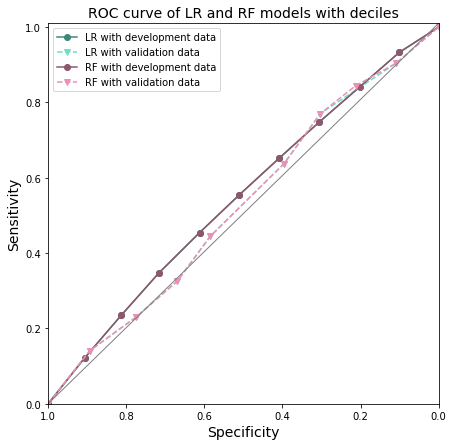

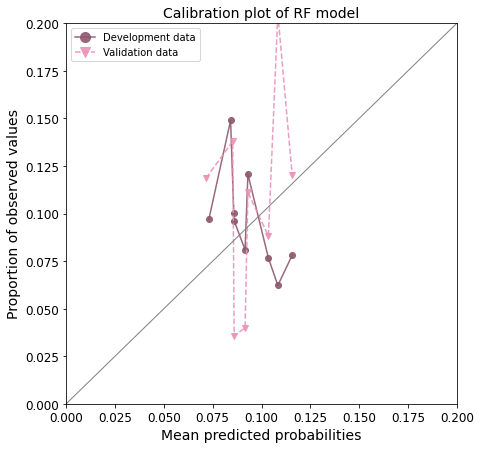

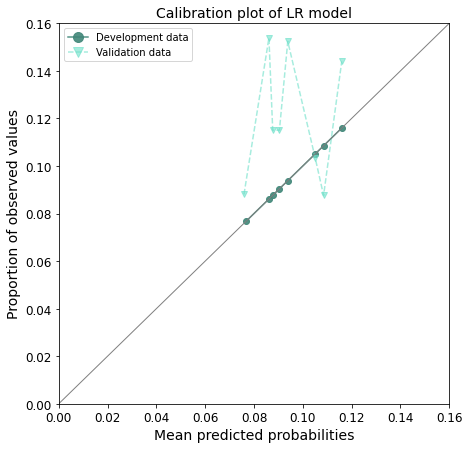

In [45]:
#build cox model for hosp prediction using non ab users' data
prob_pred_lrti_no_abs_prevl_prepandemic, prob_pred_lrti_no_abs_prevl_prepandemic_bin = cox_build('lrti', 'prevl_prepandemic', data_lrti_prevl_prepandemic, data_lrti_no_abs_prevl_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic = lr_rf_build_risk_deciles('lrti', 'prevl_prepandemic', prob_pred_lrti_no_abs_prevl_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('lrti', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic)

<lifelines.CoxPHFitter: fitted with 3641 total observations, 3621 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 3641
number of events observed = 20
   partial log-likelihood = -144.98
         time fit was run = 2023-06-29 11:01:19 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.50       1.65       0.81            -1.09             2.09                 0.34                 8.11
CCI_cat[T.medium]                0.68       1.98       0.85            -0.98             2.34                 0.38                10.41
CCI_cat[T.high]                  0.39       1.47       1.01            -1.59             2.37                 0.20                10.67
CCI_cat[T.very_high]             0.68       1.97       0.88            -1.04             2.40                 0.35                11.04
age_cat[T.25_34]                -0.73       0.48       1.23            -3.15             1.69                 0.04                 5.40
age_cat[T.35_44]                 0.23       1.26       1.01            -1.75             2.20                 0.17                 9.06
age_cat[T.45_54]                 0.77       2.16       0.88            -0.96             2.50                 0.38                12.20
age_cat[T.55_64]                 0.42       1.52       0.92            -1.38             2.23                 0.25                 9.27
age_cat[T.65_74]                 0.87       2.40       0.85            -0.78             2.53                 0.46                12.57
age_cat[T.75_more]               0.53       1.70       0.93            -1.28             2.34                 0.28                10.41
antibacterial_brit               0.07       1.07       0.16            -0.24             0.37                 0.78                 1.45
bmi_cat[T.obese]                 0.52       1.68       1.06            -1.56             2.59                 0.21                13.34
bmi_cat[T.overweight]            0.69       1.98       1.17            -1.61             2.98                 0.20                19.78
bmi_cat[T.underweight]           1.00       2.71       1.45            -1.84             3.83                 0.16                46.07
bmi_cat[T.unknown]              -0.14       0.87       1.17            -2.44             2.16                 0.09                 8.68
ethnicity[T.other]              -0.43       0.65       0.93            -2.26             1.40                 0.10                 4.05
ethnicity[T.unknown]            -1.24       0.29       0.83            -2.87             0.39                 0.06                 1.48
ethnicity[T.white]              -0.79       0.46       0.66            -2.08             0.51                 0.13                 1.66
flu_vaccine[T.yes]             -17.79       0.00    5461.67        -10722.46         10686.88                 0.00                  inf
imd[T.medium]                    0.37       1.45       0.77            -1.15             1.89                 0.32                 6.60
imd[T.unaffluent]                0.37       1.44       0.78            -1.15             1.89                 0.32                 6.61
imd[T.unknown]                   1.49       4.44       0.84            -0.16             3.14                 0.85                23.17
imd[T.very_affluent]             0.29       1.34       0.77            -1.22             1.80                 0.30                 6.08
imd[T.very_unaffluent]          -0.38       0.68       0.92            -2.19             1.42                 0.11                 4.15
region[T.east_midlands]         18.51   1.10e+08    5799.40        -11348

13203


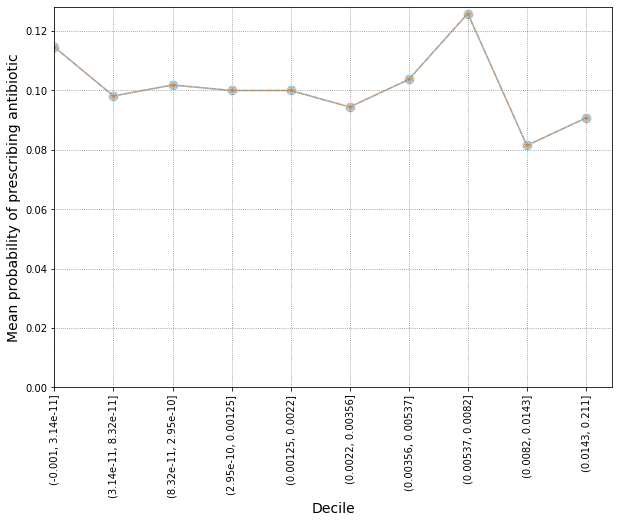


AUROC of LR for deciles with development and validation data: 0.53318 and 0.52515
AUROC of RF for deciles with development and validation data: 0.53308 and 0.52545
LR coefficients:
                                  OR  Lower CI  Upper CI
bins_(-0.001, 3.14e-11]    0.132075  0.098048  0.177911
bins_(0.00125, 0.0022]     0.114286  0.082399  0.158512
bins_(0.0022, 0.00356]     0.102902  0.074009  0.143076
bins_(0.00356, 0.00537]    0.117978  0.085689  0.162433
bins_(0.00537, 0.0082]     0.128134  0.094268  0.174166
bins_(0.0082, 0.0143]      0.079787  0.055010  0.115724
bins_(0.0143, 0.211]       0.102564  0.072783  0.144531
bins_(2.95e-10, 0.00125]   0.118785  0.086588  0.162952
bins_(3.14e-11, 8.32e-11]  0.118310  0.085926  0.162898
bins_(8.32e-11, 2.95e-10]  0.118734  0.087169  0.161728

RF feature importance:
                             rf_coef
bins_(0.0082, 0.0143]      0.251407
bins_(-0.001, 3.14e-11]    0.133412
bins_(0.00537, 0.0082]     0.102999
bins_(0.0143, 0.211]       0.098

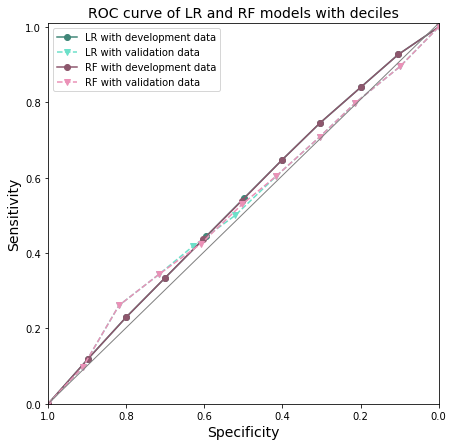

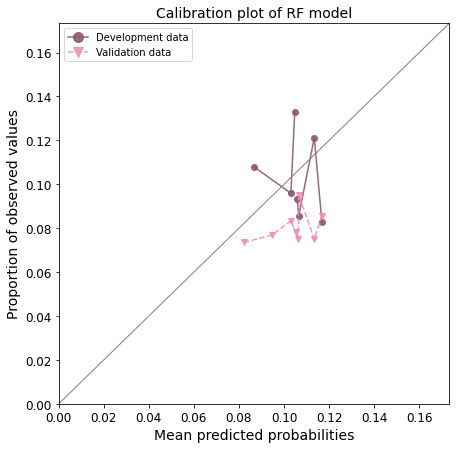

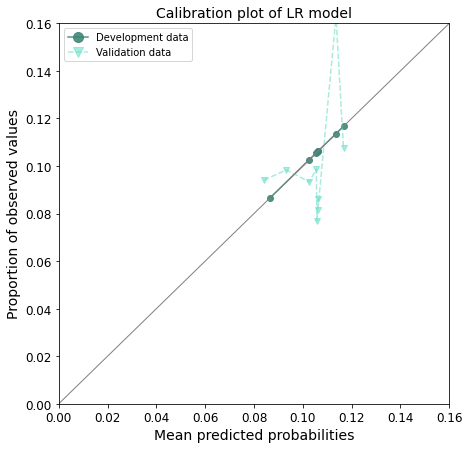

In [46]:
#build cox model for hosp prediction using non ab users' data
prob_pred_lrti_no_abs_prevl_during_pandemic, prob_pred_lrti_no_abs_prevl_during_pandemic_bin = cox_build('lrti', 'prevl_during_pandemic', data_lrti_prevl_during_pandemic, data_lrti_no_abs_prevl_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic = lr_rf_build_risk_deciles('lrti', 'prevl_during_pandemic', prob_pred_lrti_no_abs_prevl_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('lrti', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic)

<lifelines.CoxPHFitter: fitted with 5161 total observations, 5121 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 5161
number of events observed = 40
   partial log-likelihood = -320.18
         time fit was run = 2023-06-29 11:01:25 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.10       1.10       0.49            -0.86             1.05                 0.42                 2.86
CCI_cat[T.medium]                0.00       1.00       0.53            -1.04             1.05                 0.35                 2.85
CCI_cat[T.high]                 -0.02       0.98       0.65            -1.30             1.25                 0.27                 3.49
CCI_cat[T.very_high]            -0.03       0.97       0.58            -1.17             1.11                 0.31                 3.03
age_cat[T.25_34]                 1.00       2.73       0.59            -0.16             2.17                 0.85                 8.77
age_cat[T.35_44]                 0.97       2.63       0.60            -0.20             2.14                 0.82                 8.46
age_cat[T.45_54]                -1.31       0.27       1.12            -3.51             0.89                 0.03                 2.43
age_cat[T.55_64]                 0.28       1.33       0.67            -1.04             1.61                 0.35                 4.99
age_cat[T.65_74]                 0.34       1.40       0.65            -0.94             1.61                 0.39                 5.00
age_cat[T.75_more]               0.04       1.04       0.71            -1.35             1.43                 0.26                 4.18
antibacterial_brit              -0.04       0.96       0.11            -0.26             0.18                 0.77                 1.20
bmi_cat[T.obese]                 0.23       1.25       0.75            -1.25             1.70                 0.29                 5.48
bmi_cat[T.overweight]            1.10       3.01       0.79            -0.44             2.64                 0.64                14.07
bmi_cat[T.underweight]           1.74       5.70       0.87             0.03             3.45                 1.03                31.55
bmi_cat[T.unknown]               0.43       1.54       0.79            -1.11             1.97                 0.33                 7.19
ethnicity[T.other]               0.34       1.41       0.92            -1.46             2.15                 0.23                 8.56
ethnicity[T.unknown]             0.53       1.70       0.78            -1.00             2.06                 0.37                 7.83
ethnicity[T.white]               0.50       1.65       0.74            -0.94             1.95                 0.39                 7.04
flu_vaccine[T.yes]               0.00       1.00       0.53            -1.04             1.05                 0.35                 2.84
imd[T.medium]                   -1.13       0.32       0.59            -2.28             0.02                 0.10                 1.03
imd[T.unaffluent]               -0.18       0.83       0.44            -1.04             0.68                 0.35                 1.97
imd[T.unknown]                  -0.39       0.67       0.77            -1.91             1.12                 0.15                 3.07
imd[T.very_affluent]            -0.64       0.53       0.51            -1.64             0.36                 0.19                 1.44
imd[T.very_unaffluent]          -0.43       0.65       0.49            -1.38             0.52                 0.25                 1.69
region[T.east_midlands]         -0.37       0.69       0.65            -1

13039


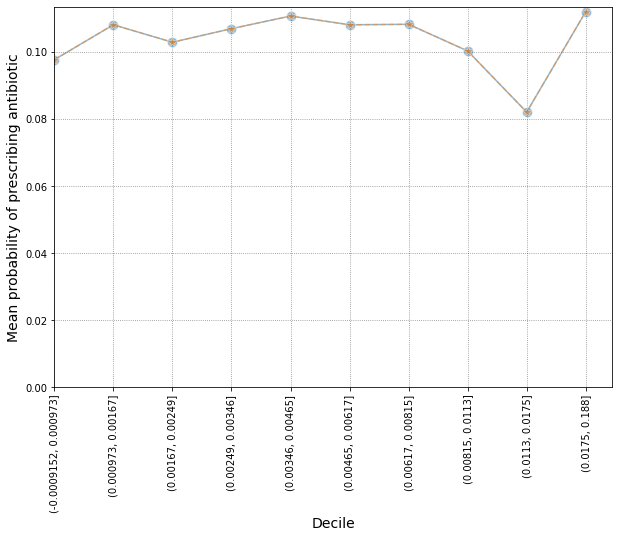


AUROC of LR for deciles with development and validation data: 0.53589 and 0.47194
AUROC of RF for deciles with development and validation data: 0.53584 and 0.47199
LR coefficients:
                                    OR  Lower CI  Upper CI
bins_(-0.0009152, 0.000973]  0.108055  0.081814  0.142713
bins_(0.000973, 0.00167]     0.114625  0.087353  0.150410
bins_(0.00167, 0.00249]      0.092279  0.068868  0.123648
bins_(0.00249, 0.00346]      0.117647  0.090034  0.153729
bins_(0.00346, 0.00465]      0.122371  0.094396  0.158636
bins_(0.00465, 0.00617]      0.106227  0.081036  0.139248
bins_(0.00617, 0.00815]      0.122736  0.094079  0.160123
bins_(0.00815, 0.0113]       0.108268  0.081973  0.142998
bins_(0.0113, 0.0175]        0.089054  0.066288  0.119637
bins_(0.0175, 0.188]         0.141454  0.110520  0.181047

RF feature importance:
                               rf_coef
bins_(0.0175, 0.188]         0.237610
bins_(0.0113, 0.0175]        0.171479
bins_(0.00167, 0.00249]      0.135927
bi

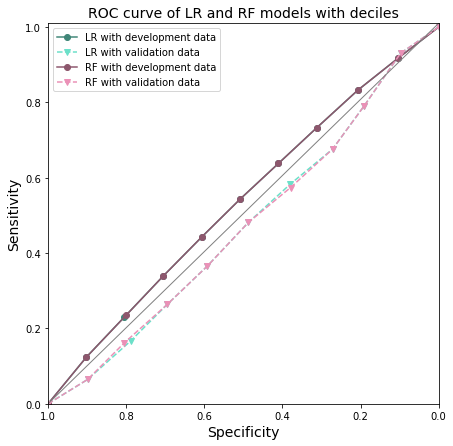

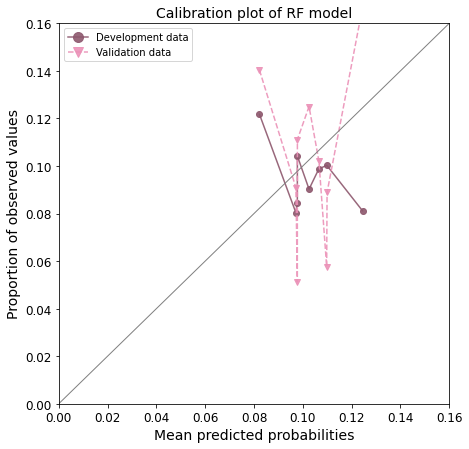

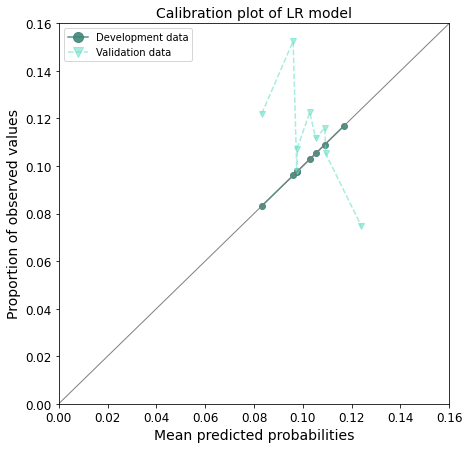

In [47]:
#build cox model for hosp prediction using non ab users' data
prob_pred_lrti_no_abs_prevl_post_2nd_lockdown, prob_pred_lrti_no_abs_prevl_post_2nd_lockdown_bin = cox_build('lrti', 'prevl_post_2nd_lockdown', data_lrti_prevl_post_2nd_lockdown, data_lrti_no_abs_prevl_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown = lr_rf_build_risk_deciles('lrti', 'prevl_post_2nd_lockdown', prob_pred_lrti_no_abs_prevl_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('lrti', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown)